In [74]:
# Basic packages

import pandas as pd
import numpy as np
import seaborn as sn
import statsmodels.api as sm
from datetime import datetime, date, timedelta
import calendar
import time
import re
import matplotlib.pyplot as plt

In [85]:
# Binance packages

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from binance.exceptions import BinanceAPIException
from binance.enums import *
import binance

In [3]:
# Sentiment analysis package

import tweepy
from flair.models import TextClassifier
from flair.data import Sentence

def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if 'POSITIVE' in str(score):
        return 'pos'
    elif 'NEGATIVE' in str(score):
        return 'neg'
    else:
        return 'neu'

def clean_expression(txt):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",txt).split())

c:\Users\User\Documents\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def buy():
    try:
        order = client.order_market_buy(
        symbol='BTCUSDT',
        quantity=0.004)

        print('Bought 0.004 BTC')
    except BinanceAPIException as e:
        print(e)
        pass

In [5]:
def sell():
    try:
        order = client.order_market_sell(
        symbol='BTCUSDT',
        quantity=0.004)

        print('Sold 0.004 BTC')
    except BinanceAPIException as e:
        print(e)
        pass

In [6]:
# Machine learning packages

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [29]:
# Twitter credentials setup

api_key = ''
api_secret = ''
access_token = ''
access_secret = ''
bearer_token = ''

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)

client = tweepy.Client(consumer_key=api_key, consumer_secret=api_secret, bearer_token=bearer_token)

In [63]:
# Extract relevant tweets

try:
    query = 'bitcoin -airdrop -#AIRDROP -giveaway -#GIVEAWAY lang:en -is:retweet'
    tweet = client.search_recent_tweets(query=query, max_results=100)
    time_retrieved = pd.Timestamp.now().round('60 min').to_pydatetime()
    lst_text = [i['text'] for i in tweet[0]]
    df_tweets = pd.DataFrame(lst_text, columns=['Tweet'])
    df_tweets['Time retreieved'] = time_retrieved

    sia = TextClassifier.load('en-sentiment')
    df_tweets['Tweet'] = df_tweets['Tweet'].apply(clean_expression)
    df_tweets['Sentiment'] = df_tweets['Tweet'].apply(flair_prediction)

    pos_score = (df_tweets['Sentiment'] == 'pos').sum() / len(df_tweets['Sentiment'])
    neg_score = (df_tweets['Sentiment'] == 'neg').sum() / len(df_tweets['Sentiment'])

    tweets_summary_list = [[time_retrieved, pos_score, neg_score]]
    df_tweets_summary = pd.DataFrame(tweets_summary_list, columns=['Retrieved Time', 'Pos rate', 'Neg rate'])
    
    big_df = pd.read_excel(r"C:\Users\User\Desktop\python files\sentiment results\results_combined.xlsx")
    big_df = pd.concat([big_df, df_tweets_summary])
    big_df = big_df[['Retrieved Time', 'Pos rate', 'Neg rate']]
    big_df.to_excel(r'C:\Users\User\Desktop\python files\sentiment results\results_combined.xlsx')
    big_df.drop_duplicates(subset=['Retrieved Time'], keep='last', inplace=True)

except Exception as e:
    print(e)


2023-01-27 16:15:59,559 loading file C:\Users\User\.flair\models\sentiment-en-mix-distillbert_4.pt


In [65]:
big_df['Retrieved Time'] = big_df['Retrieved Time'].shift()
big_df = big_df.resample('H', on='Retrieved Time').mean()
big_df.index += timedelta(hours=1)

In [80]:
# Binance packages

api_key = ''
api_secret = ''
client = Client(api_key, api_secret)
prices = pd.DataFrame(client.get_all_tickers())

today_date = str(datetime.today().day+1) + ' ' + calendar.month_abbr[datetime.today().month] + ' ' + str(datetime.today().year)

# Extract BTCUSDT data

klines = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1HOUR, '16 Jan 2023', today_date)
klines_cols = [
    'Open Time',
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Close time',
    'Quote asset volume',
    'Number of trades',
    'Taker buy base asset volume',
    'Taker buy quote asset volume',
    'Ignore']

# Setup df

df = pd.DataFrame(klines, columns=klines_cols)
df.drop_duplicates(inplace=True)

for col in df.columns:
    df[col] = pd.to_numeric(df[col])

df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
df['Open Time'] += timedelta(hours=8)

df['Open_next day'] = df['Open'].shift(-1)
df['Open_pct change'] = df['Open'].pct_change()
df['Up'] = df[['Open_next day', 'Open']].apply(lambda x: 1 if x['Open_next day'] - x['Open'] > 0 else 0, axis=1)
df = pd.merge(df, big_df, left_on='Open Time', right_on='Retrieved Time', how='left')
df = df.set_index('Open Time')
df['Pos rate_diff'] = df['Pos rate'].diff()

In [68]:
# Extract data without NA for machine learning

params = ['Pos rate', 'Pos rate_diff', 'Taker buy quote asset volume', 'Number of trades', 'Up']
df_test = df.loc['2023-01-20 10:00:00':time_retrieved,:].copy()
df_test = df_test[~df_test.isna().any(axis=1)]
print(df_test.shape)

(97, 17)


In [69]:
# Data pre-processing
X = df_test[params[:-1]].copy()
y = df_test['Up'].copy()

test_size = 0.3
X_train = X.iloc[:round(len(X)*(1-test_size))].to_numpy()
X_test = X.iloc[round(len(X)*test_size):].to_numpy()
y_train = y.iloc[:round(len(X)*(1-test_size))].to_numpy()
y_test = y.iloc[round(len(X)*test_size):].to_numpy()

# Apply random forest
rand_forest = RandomForestClassifier(max_depth=3).fit(X_train, y_train)
print(f'Train score: {rand_forest.score(X_train, y_train)}, test score: {rand_forest.score(X_test, y_test)}')

# Predict with newest data line
try:
    prev_result = df_test.loc[time_retrieved - timedelta(hours=1),:]['pred result']     # Check if last hour exist
except:
    prev_result = rand_forest.predict([df_test.iloc[-2,:][params[:-1]].values])[0]      # Last hour does not exist -> last record
    
predict_result = rand_forest.predict([df_test.iloc[-1,:][params[:-1]].values])[0]

# Buy / Sell conditions
if predict_result == 1 and prev_result == 0:
    buy()
elif prev_result == 1 and predict_result == 0:
    sell()
else:
    print('No transaction made')
prev_result = predict_result

X['pred result'] = rand_forest.predict(X.values).tolist()
X_final = X[['pred result']]

df_test = pd.merge(df_test, X_final, left_index=True, right_index=True)

Train score: 0.7941176470588235, test score: 0.6470588235294118
No transaction made


In [76]:
abs(df_test['Position_long'].diff()).sum()

23.0

In [70]:
# Condition

df_test.loc[df_test['pred result'] == 1, 'Position_long'] = 1
df_test.loc[df_test['pred result'] == 0, 'Position_long'] = 0

df_test.fillna(method='ffill', inplace=True)

# Trade fees

trade_fee = 0.001
df_test['Enter or exit position'] = (df_test['Position_long'].diff() != 0)

# P&L analysis

df_test['Daily P&L'] = (df_test['Position_long'].shift())* df_test['Open_pct change'] - df_test['Enter or exit position'] * trade_fee
df_test['Cumulative P&L'] = df_test['Daily P&L'].cumsum()

In [71]:
df_test

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,...,Open_pct change,Up,Pos rate,Neg rate,Pos rate_diff,pred result,Position_long,Enter or exit position,Daily P&L,Cumulative P&L
Open Time,,,,,,,,,,,,,,,,,,,,,
2023-01-20 13:00:00,20991.01,21037.78,20953.23,20982.27,10111.85773,1674194399999,2.122536e+08,233904,5012.19973,1.052115e+08,...,-0.004587,0,0.357500,0.642500,0.093426,0,0.0,True,NaN,NaN
2023-01-20 14:00:00,20983.09,20999.80,20926.14,20943.73,8809.62263,1674197999999,1.847094e+08,220658,4236.13847,8.882049e+07,...,-0.000377,0,0.358384,0.641616,0.000884,1,1.0,True,-0.001000,-0.001000
2023-01-20 15:00:00,20943.73,20987.00,20861.28,20959.44,9639.22592,1674201599999,2.019095e+08,243887,4874.97882,1.021165e+08,...,-0.001876,1,0.367500,0.632500,0.009116,1,1.0,False,-0.001876,-0.002876
2023-01-20 16:00:00,20958.43,20976.35,20898.79,20946.15,8841.85973,1674205199999,1.851602e+08,226066,4496.09461,9.415411e+07,...,0.000702,0,0.387500,0.612500,0.020000,1,1.0,False,0.000702,-0.002174
2023-01-20 17:00:00,20946.98,20993.99,20905.22,20959.17,8313.07021,1674208799999,1.741759e+08,220200,4115.24208,8.622594e+07,...,-0.000546,1,0.400000,0.600000,0.012500,1,1.0,False,-0.000546,-0.002720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26 09:00:00,23240.42,23247.00,23133.49,23163.24,12552.91940,1674698399999,2.911872e+08,297866,6044.01100,1.402057e+08,...,0.007806,0,0.345000,0.655000,0.013914,1,1.0,False,0.007806,0.077116
2023-01-26 10:00:00,23163.24,23265.00,23137.79,23178.98,10376.80720,1674701999999,2.407192e+08,257497,5147.79491,1.194215e+08,...,-0.003321,1,0.382500,0.617500,0.037500,1,1.0,False,-0.003321,0.073795
2023-01-26 11:00:00,23178.98,23231.89,23104.67,23136.16,10049.36738,1674705599999,2.328312e+08,247067,4977.77434,1.153325e+08,...,0.000680,0,0.300000,0.700000,-0.082500,1,1.0,False,0.000680,0.074475


<AxesSubplot: xlabel='Open Time', ylabel='Daily P&L'>

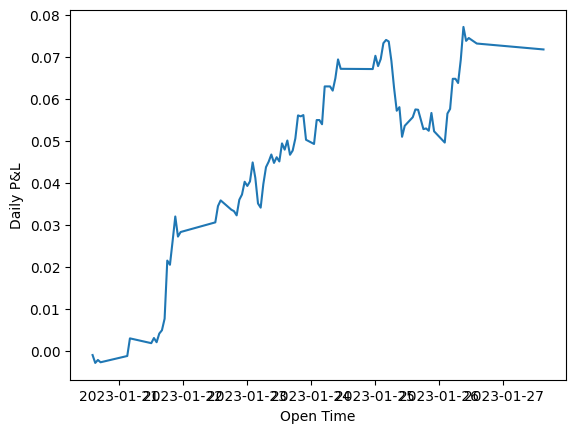

In [72]:
sn.lineplot(np.cumsum(df_test['Daily P&L']))